In [0]:
pip install xgboost

In [0]:
# LIBRARIES
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
from collections import Counter

In [0]:
query = """
 SQL Code 
)

SELECT *
FROM final_data;

"""

# Run the query using Spark
df = spark.sql(query)

# Convert to Pandas for local processing or export
pandas_df = df.toPandas()

In [0]:
# PREPROCESSING
# Selected Features
final_model_features = [
    'gender_encoded', 'recurring_type_encoded', 'urbanicity_class_encoded',
    'log_first_donation_amount', 'signup_device_encoded', 'first_gift_hour',
    'first_gift_weekday_encoded', 'distance_to_gp_bucket', 'num_gifts_on_first_day',
    'donor_set_location', 'profile_complete','gp_profile_complete', 
    'gp_age_at_gift_months', 'memo_engagement', 'memo_admin', 'got_response_same_day',
    'num_first_time_co_donors', 'first_of_month', 'last_of_month',
    'giving_tuesday','stimulus', 'cmet_code', 'is_payweek', 'py_was_first', 
    'covid', 'is_conference', 'first_gift_is_tithe', 'covid_final_wk_tue_fri'
]

X = pandas_df[final_model_features]
y = pandas_df['gave_again_within_35d']

In [0]:
# Get only numeric columns from X
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

# Compute Pearson correlation matrix
corr = X[numeric_cols].corr(method='pearson')

# Plot the heatmap
fig = px.imshow(
    corr, 
    height=1350, width=1350, 
    text_auto=".2f",
    title="Correlation Matrix (Pearson)",
    color_continuous_scale='Blues',
    color_continuous_midpoint=0,
    labels={'color': 'Correlation Coefficient'}
)
fig.show()

In [0]:
# SCALING 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Data set shape
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (953838, 28)
x_test shape: (408788, 28)
y_train shape: (953838,)
y_test shape: (408788,)


In [0]:
# TRAIN XGBOOST
scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
xgb.fit(X_train, y_train)

# CALIBRATE XGBOOST
calibrated_xgb = CalibratedClassifierCV(base_estimator=xgb, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, y_train)

# EVALUATE FINAL MODEL
y_probs = calibrated_xgb.predict_proba(X_test)[:, 1]
y_preds = calibrated_xgb.predict(X_test)

print("Calibrated XGBoost Model")
print(classification_report(y_test, y_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

/databricks/python/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Calibrated XGBoost Model
              precision    recall  f1-score   support

           0       0.69      0.69      0.69    210286
           1       0.67      0.67      0.67    198502

    accuracy                           0.68    408788
   macro avg       0.68      0.68      0.68    408788
weighted avg       0.68      0.68      0.68    408788

ROC AUC Score: 0.7473


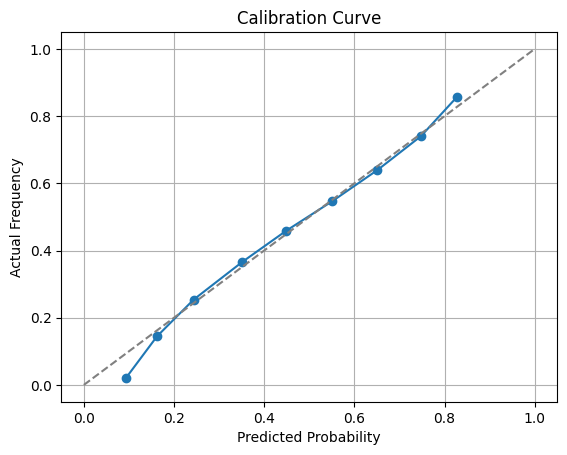

In [0]:
# CALIBRATION CURVE
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Frequency")
plt.grid(True)
plt.show()

In [0]:
# BUCKET DONORS
low_thresh = 0.3
high_thresh = 0.7

def bucketize(prob):
    if prob < low_thresh:
        return 'Low'
    elif prob < high_thresh:
        return 'Medium'
    else:
        return 'High'

buckets = [bucketize(p) for p in y_probs]

# ✅ STEP 10: GENERATE OUTPUT
output_df = pd.DataFrame({
    'donor_id': pandas_df.loc[y_test.index, 'donor_id'],
    'actual': y_test.values,
    'probability': y_probs,
    'bucket': buckets
})

# VALIDATE CALIBRATION ON SAMPLE
sample = output_df.sample(10000, random_state=42)
predicted_avg = sample['probability'].mean()
actual_avg = sample['actual'].mean()
error = abs(predicted_avg - actual_avg)

print(f"Sample (10000 donors): Predicted Avg = {predicted_avg:.3f}, Actual Avg = {actual_avg:.3f}, Error = {error:.3f}")

# DISPLAY FINAL PREDICTIONS
output_df.head()

Sample (10000 donors): Predicted Avg = 0.481, Actual Avg = 0.483, Error = 0.002


,donor_id,actual,probability,bucket
180009,1612035,0,0.302484,Medium
104307,1307849,1,0.672197,Medium
993252,707248,1,0.704885,High
1060142,1581233,1,0.696670,Medium
640928,1645608,1,0.569387,Medium


In [0]:
importances = xgb.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
display(feature_importances)

Feature,Importance
profile_complete,0.31346002
first_gift_is_tithe,0.23051229
recurring_type_encoded,0.10078125
signup_device_encoded,0.090068065
covid,0.04089002
memo_engagement,0.034077875
py_was_first,0.028787842
num_gifts_on_first_day,0.022407351
is_conference,0.019516526
log_first_donation_amount,0.011787047


In [0]:
pandas_df.loc[pandas_df['donor_id'] == 1350710]



scale_pos_weight: 1.06


/local_disk0/.ephemeral_nfs/envs/pythonEnv-9cd854bd-c542-4bec-8f27-de698626a27d/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[18:44:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost with Class Imbalance Handling
              precision    recall  f1-score   support

           0       0.70      0.67      0.68    139692
           1       0.66      0.69      0.68    132034

    accuracy                           0.68    271726
   macro avg       0.68      0.68      0.68    271726
weighted avg       0.68      0.68      0.68    271726

ROC AUC Score: 0.7437
